In [2]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
#from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F

Comparison between Torch and Keras:
- https://towardsdatascience.com/keras-vs-pytorch-for-deep-learning-a013cb63870d
- https://deepsense.ai/keras-or-pytorch/

# Torch Basics

In [3]:
x = torch.ones(2, 2, requires_grad=True)
x

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)

In [4]:
y = x + 2
y

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)

In [5]:
z = y * y * 3
out = z.mean()
z, out

(tensor([[27., 27.],
         [27., 27.]], grad_fn=<MulBackward0>),
 tensor(27., grad_fn=<MeanBackward0>))

In [6]:
out.backward()

In [7]:
# out = (z1+z2+z3+z4)/4 
# do/dx1 = do/dz1 dz1/dy dy/dx = 1/4 6y 1 = 3/2 y = 4.5
print(x.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


In [8]:
print(y.grad)
print(z.grad)

None
None


In [9]:
x = torch.randn(3, requires_grad=True)
x

tensor([ 1.0895, -0.6040,  0.2832], requires_grad=True)

In [10]:
y = x * 2
y

tensor([ 2.1789, -1.2079,  0.5664], grad_fn=<MulBackward0>)

In [11]:
# dl(y1)/dy1 = 0.1, dy1/dx1 = 2 -> dl(y1)/dx1 = 0.2
v = torch.tensor([0.1, 1.0, 0.0001], dtype=torch.float)
y.backward(v)

print(x.grad)

tensor([2.0000e-01, 2.0000e+00, 2.0000e-04])


# NN Basics

<img src="./figure/mnist_torch.png" width="800">


In [12]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [13]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

10
torch.Size([6, 1, 3, 3])


In [14]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[ 0.0705, -0.0087,  0.1197, -0.0406,  0.0450, -0.0382, -0.0280, -0.1010,
          0.0492, -0.0288]], grad_fn=<AddmmBackward>)


In [15]:
net.zero_grad()
out.backward(torch.randn(1, 10))

In [16]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss() # mse error
loss = criterion(output, target)
print(loss)

tensor(1.4128, grad_fn=<MseLossBackward>)


In [17]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

In [18]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([ 0.0071,  0.0129, -0.0063,  0.0098, -0.0021,  0.0326])


In [19]:
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

In [20]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

# Train Model

In [21]:
import torch
import torchvision
import torchvision.transforms as transforms

In [22]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

0it [00:00, ?it/s]

100%|█████████▉| 170196992/170498071 [00:58<00:00, 3076058.97it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


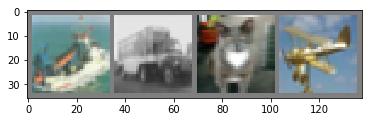

 ship truck   cat plane


In [23]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Define Network

In [24]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [25]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Train

In [26]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.173


170500096it [01:10, 3076058.97it/s]                               

[1,  4000] loss: 1.869
[1,  6000] loss: 1.686
[1,  8000] loss: 1.602
[1, 10000] loss: 1.522
[1, 12000] loss: 1.486
[2,  2000] loss: 1.398
[2,  4000] loss: 1.404
[2,  6000] loss: 1.363
[2,  8000] loss: 1.343
[2, 10000] loss: 1.324
[2, 12000] loss: 1.294
Finished Training


In [27]:
PATH = './model/cifar_net.pth'
torch.save(net.state_dict(), PATH)

## Predict

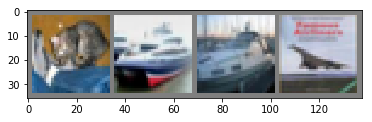

GroundTruth:    cat  ship  ship plane


In [28]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [29]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [30]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat truck   car plane
